# Utility

In [1]:
from termcolor import colored
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt

import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio
import itertools
import shutil  # file copying
import networkx as nx # graph representation
import os

from lxml import etree
from matplotlib.colors import to_hex, to_rgba

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
from robot_utils import *
import robot_utils
# help(robot_utils)

#############################################################
robot_folder = "../../robot/v11"
mesh_folder = f"{robot_folder}//mesh"
part_names = ["body","hip","shank_front","shank_back","thigh","knee","hip_back"]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
open3d :0.13.0
trimesh:3.9.35
numba  :0.53.1


In [2]:
########## discretization parameters ##############
radius_poisson = float(16) # radius for the poisson sampling
# radius_poisson = float(20) # radius for the poisson sampling
radius_knn = radius_poisson*1.6
min_radius = radius_poisson*0.5
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
# max_nn = int(28)
max_nn = int(20)
print(radius_knn)


# general argument
gmsh_args = (
    ("Mesh.Algorithm", 1), # 2D mesh algorithm (1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay, 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms)
    ("Mesh.Algorithm3D", 1), # 3D mesh algorithm (1: Delaunay, 3: Initial mesh only, 4: Frontal, 7: MMG3D, 9: R-tree, 10: HXT)    
    ("Mesh.MeshSizeExtendFromBoundary", 0),# Extend computation of mesh element sizes from the boundaries into the interior (for 3D Delaunay, use 1: longest or 2: shortest surface edge length)
    ("Mesh.MeshSizeFromPoints", 0),# Compute mesh element sizes from values given at geometry points, defualt:1
    ("Mesh.MeshSizeFromCurvature", 0),# Automatically compute mesh element sizes from curvature,defult:0
    ("Mesh.OptimizeNetgen",0), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
    ("Mesh.OptimizeThreshold",0.5), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
#         ("Mesh.AllowSwapAngle",30), # Threshold angle (in degrees) between faces normals under which we allow an edge swap
    ("Mesh.VolumeEdges",1), # Display edges of volume mesh
    ("Mesh.VolumeFaces",0), # Display faces of volume mesh
    ("Mesh.SurfaceFaces",1), # Display faces of surface mesh?
#     ("Mesh.Smoothing",8), # Number of smoothing steps applied to the final mesh
    ("Mesh.Smoothing",0), # Number of smoothing steps applied to the final mesh

#     ("Mesh.SmoothNormals",0), # Smooth the mesh normals? default 0
    ("Mesh.Binary",1), # Write mesh files in binary format (if possible)
    ("Mesh.MinimumCirclePoints",0), # Minimum number of nodes used to mesh circles and ellipses
    ("Mesh.MinimumCurvePoints",0), # Minimum number of points used to mesh curves other than lines, circles and ellipses
    ("Mesh.MinimumElementsPerTwoPi",0), # Minimum number of elements per 2 * Pi radians when the mesh size is adapted to the curvature    
    ("Mesh.RefineSteps",10), # Number of refinement steps in the MeshAdapt-based 2D algorithms, default:10

# #         ("Geometry.Tolerance",radius_poisson*0.5),# Geometrical tolerance,default:1e-8
#         ("Geometry.OCCFixDegenerated",1), # Fix degenerated edges/faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
#         ("Geometry.OCCFixSmallEdges",1), # Fix small edges when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
#         ("Geometry.OCCFixSmallFaces",1), # Fix small faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
# #         ("Geometry.OCCSewFaces",1), # Sew faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel
# #         ("Geometry.OCCBoundsUseStl",1), # Use STL mesh for computing bounds of OpenCASCADE shapes (more accurate, but slower)

    ("General.Verbosity",0), # Level of information printed during processing (0: no information), default:5
    ("General.Terminal",0), # Should information be printed on the terminal (if available)
#         ("Mesh.RandomSeed",0), # Seed of pseudo-random number generator
#         ("Mesh.QualitySup",0.5), # Only display elements whose quality measure is smaller than QualitySup

#----------------------- 2D specific argument ------------------------------#
    ("Mesh.MeshSizeMin", radius_poisson*1.25),
    ("Mesh.MeshSizeMax", radius_poisson*1.25),
)

# 3D specific argument
gmsh_args_3d = (
    ("Mesh.MeshSizeMin", radius_poisson*1.0),
    ("Mesh.MeshSizeMax", radius_poisson*1.0),
)


# # # discretize body
# # in_file_name: str = "../../mesh/soft_body_simplified.step"
# # out_file_name: str = "../../mesh/soft_body_simplified.msh"
# in_file_name: str = "../../mesh/leg_simplified.step"
# out_file_name: str = "../../mesh/leg_simplified.msh"
# vmesh,_= generateGmsh(in_file_name,out_file_name,dim=3,gui=True)
# # print(vmesh)
# vmeshSummary(vmesh)

###########################
# show_gui = True
show_gui = False
dim = 3

25.6


# discretization

Only need to run once

In [5]:
for part_name in part_names:
    print(f"{'-'*20}{part_name}{'-'*20}")
    in_step_file = f"{mesh_folder}/{part_name}.step" # input file name
    out_msh_file = f"{mesh_folder}/{part_name}.msh" # output file name for .msh
    out_stl_file = f"{mesh_folder}/{part_name}.stl" # output file name for .stl
    vmesh, _ = generateGmsh(in_step_file, out_msh_file, gmsh_args=gmsh_args,
                        gmsh_args_3d=gmsh_args_3d, gui=show_gui, dim=dim)
#     vmeshSummary(vmesh)
    # convert to stl
    convertStepToSTL(in_step_file,out_stl_file)

--------------------body--------------------
--------------------hip--------------------
--------------------shank_front--------------------
--------------------shank_back--------------------
--------------------thigh--------------------
--------------------knee--------------------
--------------------hip_back--------------------


# load descritized mesh

# vertices         = 1116
# lines            = 6249
# surface triangle = 1884
mean line length   = 20.99
COM                = [-15.027   0.216  -0.489]
COM norm           = 15.036


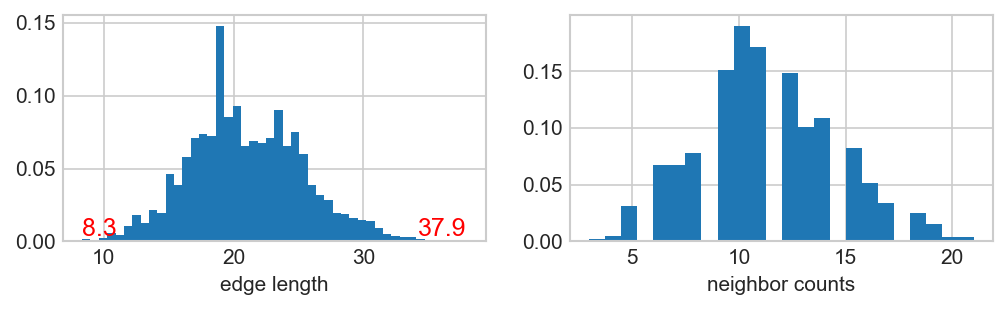

# vertices         = 137
# lines            = 663
# surface triangle = 232
mean line length   = 21.21
COM                = [60.337 -0.207  0.174]
COM norm           = 60.337


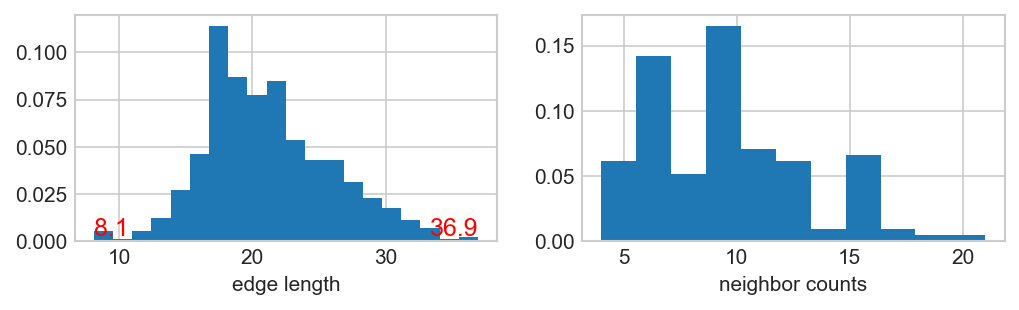

# vertices         = 126
# lines            = 591
# surface triangle = 222
mean line length   = 20.76
COM                = [  0.001   0.075 -85.912]
COM norm           = 85.912


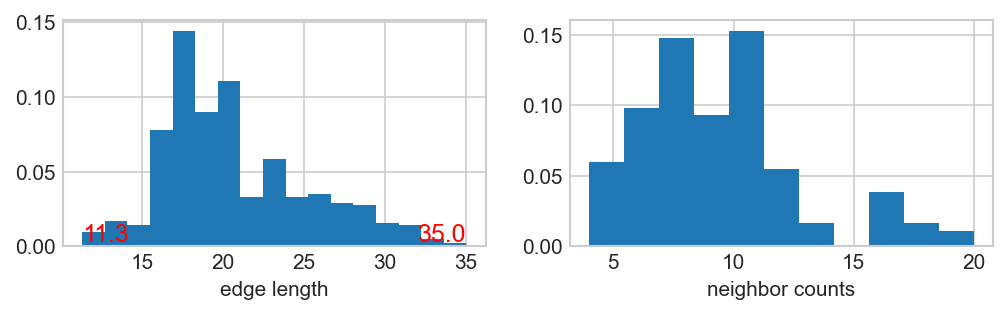

# vertices         = 128
# lines            = 596
# surface triangle = 238
mean line length   = 20.86
COM                = [ -0.583  -6.457 -70.469]
COM norm           = 70.767


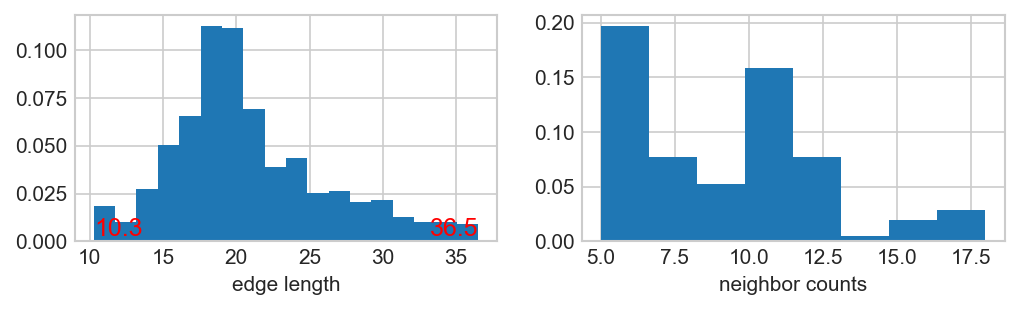

# vertices         = 189
# lines            = 925
# surface triangle = 316
mean line length   = 20.92
COM                = [  -0.137    0.679 -106.639]
COM norm           = 106.641


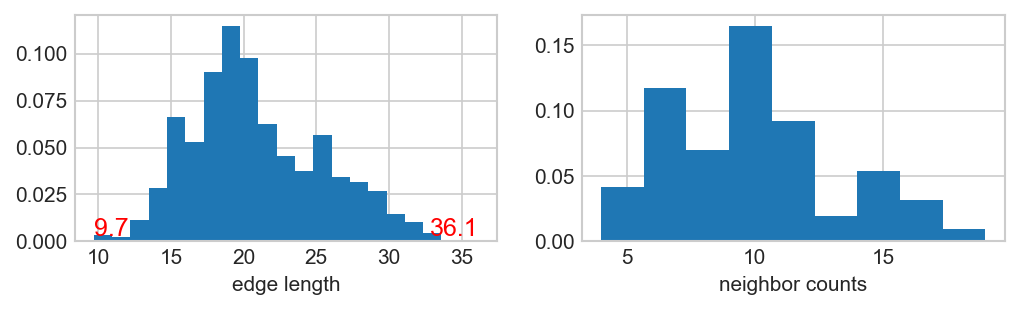

# vertices         = 167
# lines            = 818
# surface triangle = 280
mean line length   = 21.47
COM                = [  0.033  -0.361 -94.733]
COM norm           = 94.734


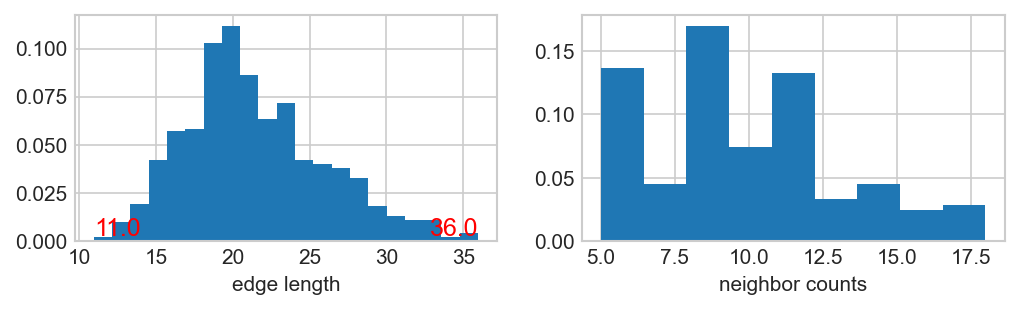

# vertices         = 229
# lines            = 1147
# surface triangle = 366
mean line length   = 21.35
COM                = [ 50.82    0.249 -56.862]
COM norm           = 76.263


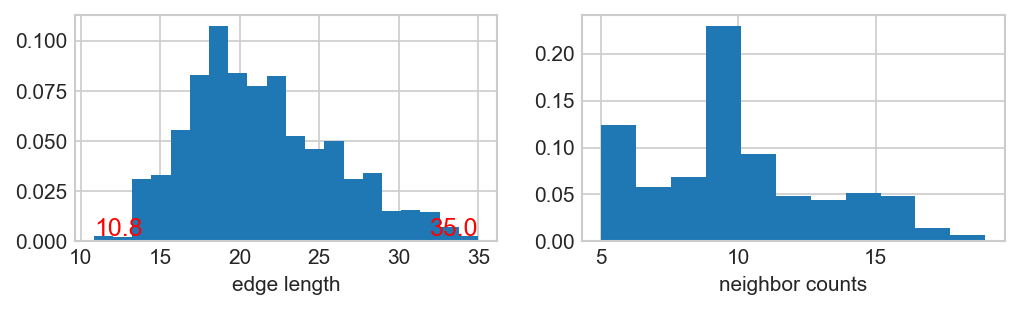

In [6]:
# for body:
# x: back->front
# y: right->left
# z: down->top

vmds = {name:
       VolumeMesh.fromGmsh(
    msh_file=f"{mesh_folder}/{name}.msh",
    stl_file = f"{mesh_folder}/{name}.stl",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4),verbose=True)
    for name in part_names
       }

In [7]:
# vmd = vmd_0.copy()
# cylinder_trimesh = trimesh.creation.cylinder(10,10)
# cylinder_trimesh.show()
# scene = trimesh.scene.Scene([trimesh.creation.cylinder(10,10),trimesh.creation.cylinder(5,20)])
# scene.show()
# vmd = VolumeMesh(vmd_leg.vertices,vmd_leg.lines,vmd_leg.triangles).copy(cmap ='pink')
# o3dShow([vmd.lsd,vmd.pcd])

In [7]:
# saving
import pickle
path = f"{robot_folder}//parts.pickle"
with open(path,"wb") as f:
    pickle.dump(vmds,f)

In [4]:
# loading
import pickle
path = f"{robot_folder}//parts.pickle"
with open(path,"rb") as f:
    vmds = pickle.load(f)

# Assemble the parts

In [23]:
# unit = Unit({"length":"mm","density":"g/mm^3"})
# unit.toSI("density")

In [5]:
############################ defineing joints geometry
# front
dx_body_f0 = 48.
dy_body_f0 = 107.
dz_body_f0 = 0.

dx_f01 = 66.
dy_f01 = 0.
dz_f01 = 0.

dx_f12 = 0.
dy_f12 = 0.
dz_f12 = 130.

# back
dx_body_b0 = 153.
dy_body_b0 = 29.
dz_body_b0 = 0.

dx_b01 = 51.
dy_b01 = 0.
dz_b01 = 100.

dx_b12 = 0.
dy_b12 = 0.
dz_b12 = 112.

tlf_body_0 = np.array([
    [0,0,1,dx_body_f0],
    [1,0,0,dy_body_f0],
    [0,1,0,dz_body_f0],
    [0,0,0,1]])# front left hip

tlf_0_1 = np.array([
    [0,0,-1,dx_f01],
    [-1,0,0,dy_f01],
    [0,1,0,dz_f01],
    [0,0,0,1]])# front left thigh 

tlf_1_2 = translation((+dx_f12,+dy_f12,-dz_f12))\
.dot(axisAngleRotation((0, 0, 1),-np.pi/2))# front left shank


trf_body_0 = np.array([
    [0, 0,1,dx_body_f0],
    [-1,0,0,-dy_body_f0],
    [0,-1,0,dz_body_f0],
    [0,0,0,1]])# front right hip

trf_0_1 = np.array([
    [0,0,-1,dx_f01],
    [1,0,0,dy_f01],
    [0,-1,0,dz_f01],
    [0,0,0,1]])# front right thigh 

trf_1_2 = translation((+dx_f12,+dy_f12,-dz_f12))\
                .dot(axisAngleRotation((0, 0, 1),np.pi/2))# front right shank

tlb_body_0 = np.array([
    [0,0,1,-dx_body_b0],
    [1,0,0,dy_body_b0],
    [0,1,0,dz_body_b0],
    [0,0,0,1]])# back left hip

tlb_0_1 = np.array([
    [1, 0, 0,dx_b01],
    [0, 1, 0,dy_b01],
    [0, 0, 1,-dz_b01],
    [0,0,0,1]])# back left knee 

tlb_1_2 = np.array([
    [1, 0, 0,dx_b12],
    [0, 1, 0,dy_b12],
    [0, 0, 1,-dz_b12],
    [0,0,0,1]])# back left shank 


trb_body_0 = np.array([
    [0, 0,1,-dx_body_b0],
    [-1,0,0,-dy_body_b0],
    [0,-1,0,dz_body_b0],
    [0,0,0,1]])# back right hip

trb_0_1 = np.array([
    [1, 0, 0,dx_b01],
    [0, 1, 0,dy_b01],
    [0, 0, 1,-dz_b01],
    [0,0,0,1]])# back right knee 

trb_1_2 = np.array([
    [1, 0, 0,dx_b12],
    [0, 1, 0,dy_b12],
    [0, 0, 1,-dz_b12],
    [0,0,0,1]])# back right shank 

In [6]:
PI = np.pi

graph = RobotDescription(unit_dict={"length": "mm"})
graph.add_nodes_from([
    (0, {"vmd": vmds["body"].copy(cmap='RdGy'), "alias": "body","color":to_rgba("r")}),  # main_body # 
    
    (1, {"vmd": vmds["hip"].copy(cmap='spring'), "alias": "lf_hip","color":to_rgba("g")}),  # front left
    (2, {"vmd": vmds["thigh"].copy(cmap='spring'), "alias": "lf_thigh"}),
    (3, {"vmd": vmds["shank_front"].copy(cmap='spring'), "alias": "lf_shank","color":to_rgba("b")}),

    (4, {"vmd": vmds["hip"].copy(cmap='summer'), "alias": "rf_hip","color":to_rgba("g")}),  # front right
    (5, {"vmd": vmds["thigh"].copy(cmap='summer'), "alias": "rf_thigh"}),
    (6, {"vmd": vmds["shank_front"].copy(cmap='summer'), "alias": "rf_shank","color":to_rgba("b")}),

    (7, {"vmd": vmds["hip_back"].copy(cmap='autumn'), "alias": "lb_hip","color":to_rgba("g")}),  # back left
    (8, {"vmd": vmds["knee"].copy(cmap='autumn'), "alias": "lb_thigh"}),
    (9, {"vmd": vmds["shank_back"].copy(cmap='autumn'), "alias": "lb_shank","color":to_rgba("b")}),

    (10, {"vmd": vmds["hip_back"].copy(cmap='winter'), "alias": "rb_hip","color":to_rgba("g")}),  # back right
    (11, {"vmd": vmds["knee"].copy(cmap='winter'), "alias": "rb_thigh"}),
    (12, {"vmd": vmds["shank_back"].copy(cmap='winter')\
          .transform(axisAngleRotation((0, 0, 1),PI))# rotate 180 deg around local z axis
        ,"alias": "rb_shank","color":to_rgba("b")}),
],
    transform=np.eye(4),
    density=176.,
    color=np.array((1, 1, 1, 1))  # white
)
#graph.nodes['body']['density'] = 100

graph.add_edges_from((
    (0, 1, {"order":0,"transform": tlf_body_0, "joint_pos": 0,"limit":{"lower":-PI,"upper":PI}}),
    (1, 2, {"order":1,"transform": tlf_0_1, "joint_pos": 0,"limit":{"lower":-5/9*PI,"upper":5/9*PI}}),
    (2, 3, {"order":2,"transform": tlf_1_2, "joint_pos": 0,"limit":{"lower":-0.5*PI,"upper":0.5*PI}}),

    (0, 4, {"order":3,"transform": trf_body_0, "joint_pos": 0,"limit":{"lower":-PI,"upper":PI}}),
    (4, 5, {"order":4,"transform": trf_0_1, "joint_pos": 0,"limit":{"lower":-5/9*PI,"upper":5/9*PI}}),
    (5, 6, {"order":5,"transform": trf_1_2, "joint_pos": 0,"limit":{"lower":-0.5*PI,"upper":0.5*PI}}),

    (0, 7, {"order":6,"transform": tlb_body_0, "joint_pos": 0,"limit":{"lower":-PI,"upper":PI}}),
    (7, 8, {"order":7,"transform": tlb_0_1, "joint_pos": 0,"limit":{"lower":-5/9*PI,"upper":5/9*PI}}),
    (8, 9, {"order":8,"transform": tlb_1_2, "joint_pos": 0,"limit":{"lower":-0.5*PI,"upper":0.5*PI}}),

    (0, 10, {"order":9,"transform": trb_body_0, "joint_pos": 0,"limit":{"lower":-PI,"upper":PI}}),
    (10, 11, {"order":10,"transform": trb_0_1, "joint_pos": 0,"limit":{"lower":-5/9*PI,"upper":5/9*PI}}),
    (11, 12, {"order":11,"transform": trb_1_2, "joint_pos": 0,"limit":{"lower":-0.5*PI,"upper":0.5*PI}}),
),
    transform=np.eye(4),
    joint_type="revolute",
    joint_pos=0,
    axis=np.array((1, 0, 0),dtype=np.float64),
    limit={  # units must be SI here
        "effort": 11,  # torque, [Nm]
        "velocity": round(487/60*2*PI)  # speed [rad/s]
}
)

# create coordinate in body space
graph.createCoordinateOXYZ(radius=15)
################## computed value ###################################

graph.updateWorldTransform(t = axisAngleRotation((0, 1, 0),-np.pi/2)) # standing orientation


# list(nx.edge_bfs(graph))

#####################################################################
for k, e in enumerate(graph.orderedEdges):
    print(f"{k}:{e}")
# graph.draw()

####################################################################
# print(graph.nodes[0]["vmd"].vertices.shape,graph.nodes[0]["vmd"].lines.shape)
# o3dShow(graph.nodes[0]["vmd"].lsd(),background_color=(0,0,0))


# world_space_pcds = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
#     graph.nodes[n]["world_transform"]) for n in graph.nodes]
# world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
#     graph.nodes[n]["world_transform"]) for n in graph.nodes]
# o3dShow(world_space_pcds+world_space_lsd+[coord_frame])


0:(0, 1)
1:(1, 2)
2:(2, 3)
3:(0, 4)
4:(4, 5)
5:(5, 6)
6:(0, 7)
7:(7, 8)
8:(8, 9)
9:(0, 10)
10:(10, 11)
11:(11, 12)


In [7]:
pi = np.pi

p_f_b0 = -pi/6 # font arm body-0
p_f_01 = pi/3 # front arm 01
p_f_12 = -pi/3 # front arm 12

p_bl_b0 = pi/12
p_br_b0 = pi/12

p_bl_01 = -p_bl_b0*2
p_br_01 = -p_br_b0*2

p_bl_12 = p_bl_b0
p_br_12 = p_br_b0

# n0 = pi/20 # body incline
n0 = 0 # body incline

graph.joint_pos = np.array([
    # front left
    -p_f_b0,      # 0
    -p_f_01,      # 1
    -p_f_12,      # 2
    # front right
    p_f_b0,      # 3
    p_f_01,      # 4
    p_f_12,      # 5
    # back left
    -p_bl_b0-n0,   # 6
    -p_bl_01,      # 7
    -p_bl_12,      # 8
    #back right
     p_br_b0+n0,   # 9
     p_br_01,      # 10
     p_br_12,      # 11
])

         # upright orientation                # account for body incline
t_base = axisAngleRotation((0, 1, 0),-np.pi/2)@axisAngleRotation((0, 1, 0),n0)

graph.updateWorldTransform(t = t_base) # standing orientation

# joint_coordiate_frams = [o3d.geometry.TriangleMesh.create_coordinate_frame(
#     size=50).transform(graph.edges[e]["world_transform"])for e in graph.edges]

link_coordinate_frames = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.nodes[n]["world_transform"])for n in graph.nodes]

world_space_pcds = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]
world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]
# o3dShow(world_space_pcds+world_space_lsd+joint_coordiate_frams)#+[coord_frame])
o3dShow(world_space_pcds+world_space_lsd+link_coordinate_frames)#+[coord_frame])

In [8]:
graph.updateWorldTransform()

world_space_pcds = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_o3dMesh = [o3d.geometry.TriangleMesh(graph.nodes[n]["vmd"].o3dMesh()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

link_coordinate_frames = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.nodes[n]["world_transform"])for n in graph.nodes]

joint_coordiate_frams = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.edges[e]["world_transform"])for e in graph.edges]

# o3dShow(world_space_pcds+world_space_lsd+link_coordinate_frames+joint_coordiate_frams + [coord_frame],background_color=(0,0,0))


###############################################
discretization_opt = dict(
    radius_poisson = radius_poisson,
    min_radius=min_radius,
    max_radius=radius_knn, 
    max_nn=max_nn,
    joint_radius = 35.,
    joint_height = 50.,
    gmsh_args=gmsh_args,
    gmsh_args_3d=gmsh_args_3d,
)


graph = graph.makeJoint(opt=discretization_opt)
#################################################

joint_cylinders = [o3d.geometry.TriangleMesh(graph.edges[e]["cylinder_parent"].o3dMesh()).transform(
    graph.nodes[e[0]]["world_transform"]) for e in graph.edges]
# o3dShow(world_space_pcds[0:]+world_space_lsd[0:]+world_space_o3dMesh[0:]+joint_cylinders[0:])#+link_coordinate_frames+joint_coordiate_frams)
# o3dShow([coord_frame.translate((0,0,0))]+world_space_pcds[0:]+world_space_lsd[0:]+joint_coordiate_frams+link_coordinate_frames+joint_cylinders[0:],background_color=(0,0,0))#+link_coordinate_frames+joint_coordiate_frams)

o3dShow(world_space_pcds[0:]+world_space_lsd[0:] + [coord_frame]+link_coordinate_frames+joint_coordiate_frams)


# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
# o3dShow([robot_lsd]+joint_cylinders[0:])


# o3dShow(o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(graph.nodes[0]["vmd"]["vertices"]),
#     o3d.utility.Vector2iVector(graph.nodes[0]["vmd"]["lines"])), background_color=(1, 1, 1)
# )

# saving
import pickle
path = f"{robot_folder}//robot.pickle"
with open(path,"wb") as f:
    pickle.dump(graph,f)
    
# # loading
# import pickle
# path = f"{robot_folder}//robot.pickle"
# with open(path,"rb") as f:
#     graph = pickle.load(f)

(0, 1):59,59
(0, 4):59,59
(0, 7):59,59
(0, 10):59,59
(1, 2):59,59
(2, 3):59,59
(4, 5):59,59
(5, 6):59,59
(7, 8):59,59
(8, 9):59,59
(10, 11):59,59
(11, 12):59,59


In [165]:
knee_angle = np.pi/10.*0
# knee_angle = np.pi*0.04
arm_swing_angle = 0/180*np.pi
# shoulder_angle = np.pi/6
shoulder_angle = 0
lower_arm_angle = 0/180*np.pi


graph.joint_pos = np.array([
    # front left
    -arm_swing_angle,               # 0
    -np.pi/2+shoulder_angle,        # 1
    lower_arm_angle,               # 2
    # front right
    arm_swing_angle,               # 3 
    np.pi/2-shoulder_angle,         # 4  
    -lower_arm_angle,               # 5
    # back left
    0-knee_angle,               # 6     
    knee_angle,        # 7   
    0-knee_angle,               # 8
    # back right
    0+knee_angle,               # 9        
    knee_angle,         # 10 
    0+knee_angle               # 11   
])     

# graph.updateWorldTransform()
# graph.setJointPosArrFast([0]*12)
# t= eye(4), world thransform equivalent to root space transfrom
graph.updateWorldTransformFast(np.eye(4))


# 9: back left foot
# 12:back right foot
t_sensor = np.eye(4)
t_sensor[:3,3] = [0,0,-130.]

node_left_foot = graph.nodes[9]
node_right_foot = graph.nodes[12]

t_world_left_foot_sensor = node_left_foot["world_transform"]@t_sensor
t_world_right_foot_sensor = node_right_foot["world_transform"]@t_sensor

with np.printoptions(precision=2, suppress=True, threshold=5):
    print(t_world_left_foot_sensor[:3,3])
    print(t_world_right_foot_sensor[:3,3])
    

world_space_pcds = [o3d.geometry.PointCloud(node["vmd"].pcd()).transform(
    node["world_transform"]) for name,node in graph.nodes(data=True)]
world_space_lsd = [o3d.geometry.LineSet(node["vmd"].lsd()).transform(
    node["world_transform"]) for name,node in graph.nodes(data=True)]
world_space_o3dMesh = [o3d.geometry.TriangleMesh(node["vmd"].o3dMesh()).transform(
    node["world_transform"]) for name,node in graph.nodes(data=True)]
link_coordinate_frames = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(node["world_transform"])for name,node in graph.nodes(data=True)]
joint_coordiate_frams = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(edge["world_transform"])for n0,n1,edge in graph.edges(data=True)]

[-493.   80.    0.]
[-493.  -80.    0.]


# create spring-mass representation

dict_id2node=
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
dict_id2edge=
{0: (0, 1), 1: (0, 4), 2: (0, 7), 3: (0, 10), 4: (1, 2), 5: (2, 3), 6: (4, 5), 7: (5, 6), 8: (7, 8), 9: (8, 9), 10: (10, 11), 11: (11, 12)}
----------------------------------------
id_vertices:
label           length  indices
part            4266    [   0 1296 1532 1817 2002 2238 2523 2708 3035 3300 3487 3814 4079 4266]
anchor          24      [4266 4268 4270 4272 4274 4276 4278 4280 4282 4284 4286 4288 4290]
part_coord      78      [4290 4296 4302 4308 4314 4320 4326 4332 4338 4344 4350 4356 4362 4368]
joint_coord     72      [4368 4374 4380 4386 4392 4398 4404 4410 4416 4422 4428 4434 4440]
----------------------------------------
id_lines:
label           length  indices
part            26324   [    0  8548 10232 11920 12850 14531 16224 17154 19177 20780 21742 23765
                         25367 26324]
anchor          12      [26324 26325 26326 26327 26328 26329 26330 26

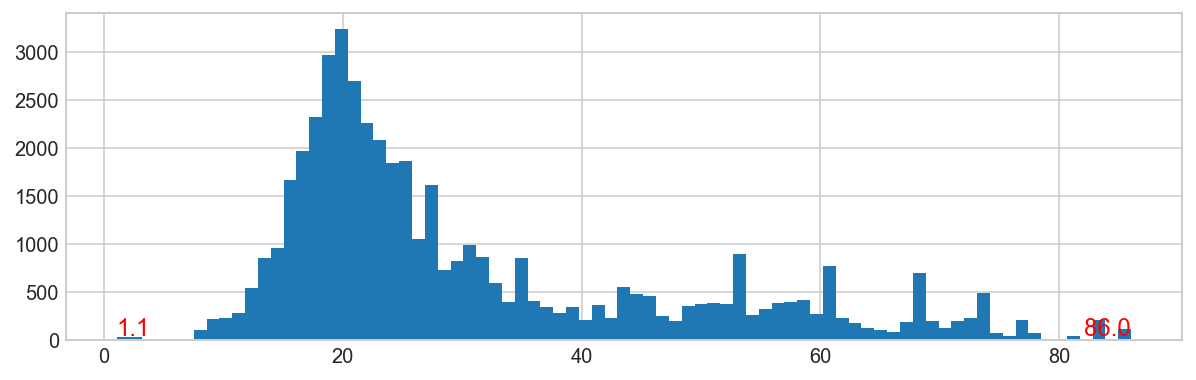

In [9]:
# number of attachment lines per point in the attached coordinates
# num_attach_per_coord = 20
num_attach_per_coord = 20

# num of friction spring (spring connecting the two parts of the joint) per mass
# num_fri_spring_per_mass = 20
num_fri_spring_per_mass = 20

######################################################################
dict_id2node = dict(enumerate(graph.nodes)) # dict of index to node
dict_node2id = dict(zip(graph.nodes, range(len(graph.nodes)))) # dict of node to index
print(f"dict_id2node=\n{dict_id2node}")
dict_id2edge = dict(enumerate(graph.edges)) # dict of index to edges
dict_edge2id = dict(zip(graph.edges, range(len(graph.edges))))
print(f"dict_id2edge=\n{dict_id2edge}","-"*40, sep = "\n")


graph.updateWorldTransform()

# ############################# transform vertices local to world ############
part_vertices = [applyTransform(graph.nodes[n]["vmd"].vertices,
                                graph.nodes[n]["world_transform"]) for n in graph.nodes]
anchor_vertices = [applyTransform(graph.edges[e]['anchor'],
                                  graph.edges[e]["world_transform"]) for e in graph.orderedEdges]
part_coord_vertices = [applyTransform(graph.nodes[n]['coord'],
                                      graph.nodes[n]["world_transform"]) for n in graph.nodes]
joint_coord_vertices = [applyTransform(graph.edges[e]['coord'],
                                       graph.edges[e]["world_transform"]) for e in graph.orderedEdges]


vertices, id_vertices = flattenNamedArrays((
    ("part", part_vertices),
    ("anchor", anchor_vertices),
    ("part_coord", part_coord_vertices),
    ("joint_coord", joint_coord_vertices)),dim=3)

# colors of the vertices
part_colors = np.vstack([graph.nodes[n]["vmd"]["vertices_color"] for n in graph.nodes])
colors = np.zeros((len(vertices), 3))
colors[:len(part_colors)] = part_colors

###################################################################
vid_part = id_vertices["part"]
vid_anchor = id_vertices["anchor"]
vid_part_coord = id_vertices["part_coord"]
vid_joint_coord = id_vertices["joint_coord"]

for k, n in enumerate(graph.nodes):
    graph.nodes[n]["vertex_start_id"] = vid_part[k]
    graph.nodes[n]["coord_start_id"] = vid_part_coord[k]
for k, e in enumerate(graph.orderedEdges):
    graph.edges[e]["coord_start_id"] = vid_joint_coord[k]
    graph.edges[e]["anchor_start_id"] = vid_anchor[k]
############################################################
part_triangles = [graph.nodes[n]["vmd"].triangles +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

triangles = np.vstack(part_triangles)
###############################################################
# part surfaces
part_surface_id = np.unique(triangles)
is_surface = np.zeros(len(vertices), dtype=bool)
is_surface[part_surface_id] = True
###############################################################
# lines
part_lines = [graph.nodes[n]["vmd"].lines +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

anchor_lines = [(graph.edges[e]["anchor_start_id"],
                 graph.edges[e]["anchor_start_id"]+1) for e in graph.orderedEdges]

part_coord_self_lines = [graph.nodes[n]["coord_start_id"] +
                         graph.nodes[n]["coord_self_lines"] for n in graph.nodes]
joint_coord_self_lines = [graph.edges[e]["coord_start_id"] +
                          graph.edges[e]["coord_self_lines"] for e in graph.orderedEdges]


# connecting coordinate to the body parts
part_coord_attach_lines = []
for k, n in enumerate(graph.nodes):
    part_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[k],
                  right_vertices=part_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[k],
                  right_id_start=vid_part_coord[k]))

# connecting coordinate to the joint-parent
joint_coord_attach_lines = []
for k, e in enumerate(graph.orderedEdges):
    parent_id = dict_node2id[e[0]]
    joint_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[parent_id],  # parent vertices
                  right_vertices=joint_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[parent_id],
                  right_id_start=vid_joint_coord[k]))


joints = []

for k, e in enumerate(graph.orderedEdges):
    edge = graph.edges[e]
    parent = e[0]
    child = e[1]
    parent_id = dict_node2id[e[0]]
    child_id = dict_node2id[e[1]]
    left = edge["id_joint_parent"]+vid_part[parent_id]
    right = edge["id_joint_child"]+vid_part[child_id]
    joint_k = Joint(
        left=left, # indices of the left mass
        right=right, # indices of the right mass
        vertices=vertices, # flattened array of vertices
        anchor=anchor_lines[k], # anchoring points (index) for the joint
        left_coord=edge["coord_start_id"],  # start id of the left coordinate
        right_coord=graph.nodes[child]["coord_start_id"], # start id of the right coordinate (child)
        min_radius = min_radius*0.5,
        num_spring_per_mass = num_fri_spring_per_mass,
        axis=edge["axis"]
    )
    joints.append(joint_k)

rot_springs = [j.rot_spring for j in joints]
fri_springs = [j.fri_spring for j in joints]


# lines:
# parts_lines = part_k_lines for k in range(#nodes)
# anchors_lines
# oxyz_self_springs
# oxyz_anchor_springs
# rotation springs
# resetable friction springs

coord_self_lines = part_coord_self_lines+joint_coord_self_lines
coord_attach_lines = part_coord_attach_lines+joint_coord_attach_lines

lines,id_lines = flattenNamedArrays((
    ("part",part_lines),
    ("anchor",anchor_lines),
    ("rot_spring",rot_springs),
    ("fri_spring",fri_springs),
    ("coord",coord_self_lines),
    ("coord_attach",coord_attach_lines)),dim=2)

# whether the springs has surface end-points
lines_is_surface = np.bitwise_or.reduce(np.isin(lines,part_surface_id),1)

########################## print info #################################################
######## print id_vertices
print("id_vertices:")
print(f"{'label':16s}{'length':8s}{'indices'}")
for label,ids in id_vertices.items():
    print(f"{label:16s}{ids[-1]-ids[0]:<8d}{ids}".replace('\n', '\n'+' '*24))
print("-"*40)

######## print id_lines
print("id_lines:")
print(f"{'label':16s}{'length':8s}{'indices'}")
for label,ids in id_lines.items():
    print(f"{label:16s}{ids[-1]-ids[0]:<8d}{ids}".replace('\n', '\n'+' '*24))
print("-"*40)

lines_length = np.linalg.norm(vertices[lines[:,0]] - vertices[lines[:,1]],axis=1)
plt.figure(figsize=(10,3))
n,bins,_ =plt.hist(lines_length,bins="auto")
plt.text(bins[0],0,f"{bins[0]:.1f}",ha="left",va="bottom",fontsize="large",color='r')
plt.text(bins[-1],0,f"{bins[-1]:.1f}",ha="right",va="bottom",fontsize="large",color='r')

plt.show()

In [10]:
# joint_radius = 40.
# joint_height = 40.

# cylinder_spec = dict(center=(0, 0, 0), axis=(1, 0, 0),
#                      radius=joint_radius, height=joint_height)
# cyliner_k, _ = generateGmsh(gmshGeoFcn=gmshGeoAddCylinder, gmsh_geo_kwargs=cylinder_spec,
#                             gmsh_args=gmsh_args+gmsh_args_3d, gmsh_args_3d={}, gui=True)

# vmd_cylinder = VolumeMesh.fromGmsh(
#             cyliner_k, min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn)
# o3dShow([vmd_cylinder.lsd(),vmd_cylinder.pcd(),vmd_cylinder.o3dMesh(),coord_frame])

In [11]:
num_body = len(graph.nodes)
joint_vertex_id = np.sort(np.stack([(j.left,j.right) for j in joints]).ravel())
# lines connected to joints
lines_is_joint = np.bitwise_or.reduce(np.isin(lines,joint_vertex_id),1)
# lines parts only
lines_is_part = np.zeros(len(lines),dtype=bool)
lines_is_part[id_lines["part"][1]:id_lines["part"][-1]] = True
# selected sensor lines (bool)
# lines_selected = ~lines_is_surface  * lines_is_part* ~lines_is_joint #bone
# lines_selected = lines_is_surface  * lines_is_part* ~lines_is_joint # skin
lines_selected = lines_is_part* ~lines_is_joint # all


####################################################
robot_lsd = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(vertices),
    o3d.utility.Vector2iVector(lines))
robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))

############# selected edges #########################
# robot_lsd.paint_uniform_color((0.1,0.1,0.1))
# colors = np.asarray(robot_lsd.colors)
# # colors[np.logical_not(lines_is_surface)] = (1,1,1)
# colors[lines_selected] = (1,1,1)
# colors[lines_is_joint] = (1,0,0)
# robot_lsd.colors = o3d.utility.Vector3dVector(colors)
#######################################################
# robot_lsd.paint_uniform_color((0.1,0.1,0.1))
# step =  (id_lines[num_body])//128
# colors = np.asarray(robot_lsd.colors)
# colors[np.logical_not(lines_is_surface)] = (0.2,0.2,0.2)
# colors[range(0,id_lines[num_body],step)] = (1,1,1)
# robot_lsd.colors = o3d.utility.Vector3dVector(colors)

# o3dShow([robot_lsd,coord_frame],background_color=(0,0,0))

In [12]:
# o3dShow(robot_lsd)
# export
xyz_all_trans = vertices.copy()

# xyz_all_trans = applyTransform(xyz_all_trans,axisAngleRotation((0, 1, 0),-np.pi/2))

min_bound = xyz_all_trans.min(axis=0)
# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+0]))/1000
# xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]]))/1000
# xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+200]))/1000


joints_list = [joint.toDict() for joint in joints]
data = {
    "radius_poisson":radius_poisson*1e-3,# convert to m
    "vertices":xyz_all_trans.tolist(),
    "edges":lines.tolist(),
    "triangles":triangles.tolist(),
    "is_surface":is_surface.tolist(),
    "id_vertices":{key:arr.tolist() for key,arr in id_vertices.items()},
    "id_edges":{key:arr.tolist() for key,arr in id_lines.items()},
    "colors":colors.tolist(),
    "joints":joints_list,
#     "is_surface_edges":lines_is_surface.tolist(), # surface lines
    "id_selected_edges":np.flatnonzero(lines_selected).tolist() # selected edges for spring strain
}



print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines.shape)


robot_lsd = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(xyz_all_trans),
    o3d.utility.Vector2iVector(lines))
robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
o3dShow([robot_lsd,o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1, origin=[0, 0, 0])])

# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack
# Write msgpack file
with open('../flexipod_12dof.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)
    
# # Read msgpack file
# with open('../flexipod_12dof.msgpack','rb') as data_file:
#     # data_loaded = json.load(data_file)
#     data_loaded = msgpack.unpack(data_file)

[-0.10806942 -0.30798148  0.        ]
[0.07187565 0.30798148 0.55661344]
(4440, 3)
(46703, 2)


##  generate URDF

In [13]:
urdf_path = f"{robot_folder}//urdf/robot.urdf"
graph.exportURDF(path= urdf_path,use_fine_mesh=True)

URDF path:D:\repo\FlexipodFast\robot\v11\urdf\robot.urdf

<?xml version='1.0' encoding='ASCII'?>
<robot name="robot">
  <link name="0">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.6162799829535238"/>
      <inertia ixx="0.0023255075838833346" ixy="2.0175850590575663e-20" ixz="3.15683461770036e-05" iyy="0.004910519848350381" iyz="1.3284306943909567e-20" izz="0.006275332679553604"/>
    </inertial>
    <visual>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/0.obj"/>
      </geometry>
      <material name="#ff0000ff">
        <color rgba="1.0 0.0 0.0 1"/>
      </material>
    </visual>
    <collision>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/0.obj"/>
      </geometry>
    </collision>
  </link>
  <link name="1">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.07269017067211427"/>
      <inertia ixx=

# VHACD

In [14]:
import glob
import pybullet as p
import os
from joblib import Parallel, delayed
import shutil

def vhacd(name_in,name_out):
    physicsClientId = p.connect(p.DIRECT)
    p.vhacd(name_in, name_out, "", concavity=0.00005, resolution=8000000, 
        maxNumVerticesPerCH=256, depth=32,planeDownsampling=4,convexhullDownsampling=4,
            minVolumePerCH =0.00001,
           physicsClientId = physicsClientId)
    p.disconnect(physicsClientId)
    
urdf_dir = f"{robot_folder}//urdf"
mesh_dir = f"{urdf_dir}//mesh"
mesh_original_dir = f"{urdf_dir}/mesh/original"

if not os.path.exists(mesh_original_dir):
    print("moving original mesh to 'mesh/original/'")
    os.mkdir(mesh_original_dir)

for obj_file in glob.glob(f"{mesh_dir}/*.obj"):
    base_name = os.path.basename(obj_file)
    shutil.move(obj_file,f"{mesh_original_dir}/{base_name}")
original_obj_list = glob.glob(f"{mesh_original_dir}/*.obj")
converted_obj_list = [f"{mesh_dir}/{os.path.basename(obj)}" for obj in original_obj_list]

n_jobs = int(min(os.cpu_count()*0.8,len(original_obj_list)))
_=Parallel(n_jobs = n_jobs,verbose=1)(
    delayed(vhacd)(n_in,n_out) for n_in,n_out in zip(original_obj_list,converted_obj_list))

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done   2 out of  13 | elapsed:   17.0s remaining:  1.6min
[Parallel(n_jobs=13)]: Done  13 out of  13 | elapsed:   53.5s finished


In [56]:
# k = 1
# name_in = original_obj_list[k]
# name_out = converted_obj_list[k]
# vhacd(name_in,name_out)

# # check the file
# name_out = os.path.abspath(name_out)
# ! $name_out

# check pybullet

In [21]:
import numpy as np
import pybullet as p
import time
import pybullet_data
from scipy.spatial.transform import Rotation

##########################################
urdf_path = f"{robot_folder}//urdf/robot.urdf"
####################################################
use_fixed_base=0

gui = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=gui)
p.setGravity(0, 0, -10)
# robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui,useFixedBase=1,flags = p.URDF_USE_SELF_COLLISION)
robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui,useFixedBase=use_fixed_base,flags = p.URDF_USE_SELF_COLLISION)

plane = p.loadURDF("plane.urdf")

# quat = Rotation.from_euler('xyz',[0,-np.pi/2,0]).as_quat()
# p.resetBasePositionAndOrientation(robot_id, [0, 0, 0.5], quat)

# # ##################################################
while (p.getConnectionInfo(physicsClientId=gui)["isConnected"]):
    #p.setJointMotorControlArray(robot_id,np.arange(p.getNumJoints(robot_id)),p.POSITION_CONTROL,joint_pos)
    p.stepSimulation(physicsClientId=gui)
    #time.sleep(0.01)
    
# p.disconnect()

In [22]:
p.disconnect()

error: Not connected to physics server.

In [4]:
import numpy as np
import pybullet as p
import time
import pybullet_data
from scipy.spatial.transform import Rotation

##########################################
urdf_path = "../../data/urdf/12dof/robot.urdf"
####################################################
use_fixed_base=0

gui = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=gui)
p.setGravity(0, 0, -10)
# robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui,useFixedBase=1,flags = p.URDF_USE_SELF_COLLISION)
robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui,useFixedBase=use_fixed_base,flags = p.URDF_USE_SELF_COLLISION)

plane = p.loadURDF("plane.urdf")


joint_pos = np.array([
    # front left
    -np.pi/2,               # 0
    -np.pi/2,        # 1
    0,               # 2
    # front right
    np.pi/2,               # 3 
    np.pi/2,         # 4  
    0,               # 5
    # back left
    -np.pi/2,               # 6     
    -np.pi/2,        # 7   
    0,               # 8
    # back right
    np.pi/2,               # 9        
    np.pi/2,         # 10 
    0                # 11   
]) 
dof = len(joint_pos)
for k in range(dof):
    p.resetJointState(robot_id, k, targetValue=joint_pos[k])
    
# quat = Rotation.from_euler('xyz',[0,-np.pi/2,0]).as_quat()
# p.resetBasePositionAndOrientation(robot_id, [0, 0, 0.5], quat)

p.setJointMotorControlArray(robot_id, list(range(dof)), controlMode= p.POSITION_CONTROL,
                                    targetPositions=joint_pos)
# for k in range(1000):
#     p.stepSimulation(physicsClientId=gui)
    
# # # ##################################################
while (p.getConnectionInfo(physicsClientId=gui)["isConnected"]):
    #p.setJointMotorControlArray(robot_id,np.arange(p.getNumJoints(robot_id)),p.POSITION_CONTROL,joint_pos)
    p.stepSimulation(physicsClientId=gui)
    #time.sleep(0.01)
    view_matrix = p.computeViewMatrix(np.array([1.,1.,0.]),np.array([0.,0.,0.]),np.array([0.,0.,1.]))
    break
    
p.disconnect()

In [3]:
import pybullet as p
import pybullet_data
import numpy as np
physicsClient = p.connect(p.GUI)#or p.DIRECT for non-graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #used by loadURDF
p.setGravity(0,0,-10)
# planeId = p.loadURDF("plane.urdf")
cubeStartPos = [0,0,0]
cubeStartOrientation = p.getQuaternionFromEuler([0,0,0])
boxId = p.loadURDF("r2d2.urdf",cubeStartPos, cubeStartOrientation)
p.stepSimulation()
cubePos, cubeOrn = p.getBasePositionAndOrientation(boxId)
print(cubePos,cubeOrn)

camera_eye = np.array([0.,1.,0.])
target_pos = np.array([0.,0.,0.])
camera_up = np.array([0.,0.,1.])
fov = 90
aspect = 1
nearVal = 0
farVal = 10
width = 1000
height = 1000

viewMatrix = p.computeViewMatrix(camera_eye,target_pos,camera_up)
projectionMatrix = p.computeProjectionMatrixFOV(fov,aspect,nearVal,farVal)
_,_,rgbPixels,depthPixels,segmentationMaskBuffer=p.getCameraImage(width,height,viewMatrix,projectionMatrix)

p.disconnect()

(1.2618370655997593e-21, 1.0619299914168979e-24, -0.00017361111111111112) (4.801806680334471e-22, 6.571396703901434e-21, 1.992821649693796e-22, 1.0)


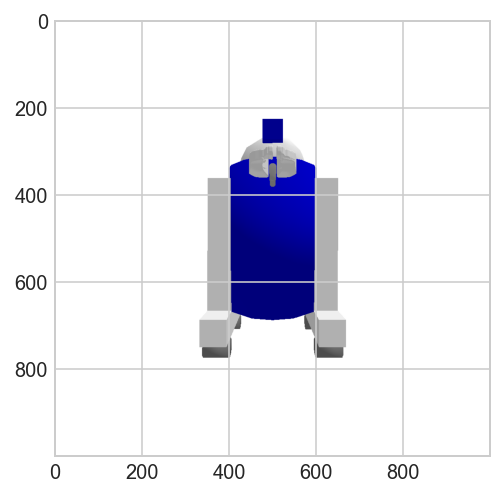

In [5]:
import matplotlib.pyplot as plt
plt.imshow(rgbPixels)

In [3]:
from flexipod_env import FlexipodEnv
import time
from phase_indication import phaseIndicatorPair
env = FlexipodEnv()
env.info=True
obs = env.reset()

setting humanoid_task=True
spring_strain size==0, removed from OBS_DICT
Loading robot graph takes 0.0 s.
-455.844415096121
-455.844415096121


In [151]:
info

{'t': 12.194999694824219,
 'com': (0.39658278226852417, 0.10065869987010956, 0.4517594277858734),
 'tn': 0.5879995822906494,
 'r_cyclic': 0.8179801083120106,
 'r_vel': 1.2247391395270824,
 'r_orientation': 1.0,
 'r_quad_ctrl': 0.9999691332052248,
 'r_joint_limit': 1.0,
 'r_acc': 1.0}

In [58]:
obs = env.reset()

pi = np.pi

p_f_b0 = -pi/6 # font arm body-0
p_f_01 = pi/4 # front arm 01
p_f_12 = 0 # front arm 12

p_bl_b0 = pi/12 # back leg left body-0
p_br_b0 = pi/12 # back leg right body-0

p_bl_01 = -p_bl_b0*2
p_br_01 = -p_br_b0*2

p_bl_12 = p_bl_b0
p_br_12 = p_br_b0

n0 = pi/30 # body incline
# n0 = 0 # body incline

#
n1 = pi/9.5
n2 = pi/12

joint_pos = np.array([
# front left
    -p_f_b0,
    -p_f_01,
    -p_f_12,
# front right
    p_f_b0,
    p_f_01,
    p_f_12,
# back left
    -p_bl_b0-n0,
    -p_bl_01,
    -p_bl_12,
#back right
     p_br_b0+n0,
     p_br_01,
     p_br_12,
])

while True:
    delta_p = 2*(joint_pos-env.joint_pos)
    if np.linalg.norm(delta_p)>5e-2:
        env.step(delta_p)
    else:
        break

for p_bl_b0,p_br_b0 in zip([n2,n1,n2]*999,[n1,n2,n1]*999):
    
    p_bl_01 = -p_bl_b0*2
    p_br_01 = -p_br_b0*2

    p_bl_12 = p_bl_b0
    p_br_12 = p_br_b0
    
    joint_pos = np.array([
        # front left
            -p_f_b0,
            -p_f_01,
            -p_f_12,
        # front right
            p_f_b0,
            p_f_01,
            p_f_12,
        # back left
            -p_bl_b0-n0,
            -p_bl_01,
            -p_bl_12,
        #back right
             p_br_b0+n0,
             p_br_01,
             p_br_12,
    ])

    while True:
        delta_p = 2.*(joint_pos-env.joint_pos)
        if np.linalg.norm(delta_p)>4e-2:
            env.step(delta_p)
        else:
            break

TimeoutError: tried too many times

In [7]:
pi = np.pi


def exampleAction(self,
                  n0=pi/60, # body incline
                  n1=pi/9.5,
                  n2=pi/12
                  ):
    

    p_f_b0 = -pi/6  # font arm body-0
    p_f_01 = pi/3  # front arm 01
    p_f_12 = -pi/4  # front arm 12

#     n0 = pi/60  # body incline
#     # n0 = 0 # body incline

#     n1 = pi/9.5
#     n2 = pi/12
    while True:
        for p_bl_b0, p_br_b0 in zip([n2, n1], [n1, n2]):

            p_bl_01 = -p_bl_b0*2
            p_br_01 = -p_br_b0*2

            p_bl_12 = p_bl_b0
            p_br_12 = p_br_b0

            joint_pos = np.array([
                # front left
                -p_f_b0,
                -p_f_01,
                -p_f_12,
                # front right
                p_f_b0,
                p_f_01,
                p_f_12,
                # back left
                -p_bl_b0-n0,
                -p_bl_01,
                -p_bl_12,
                # back right
                p_br_b0+n0,
                p_br_01,
                p_br_12
            ])

            while True:
                delta_p = 1.5*(joint_pos-self.joint_pos)
                if np.linalg.norm(delta_p) > 4e-2:
                    yield delta_p
                else:
                    yield delta_p
                    break


obs = env.reset()
exp = exampleAction(env)
t = time.time()
while True:
    
    while time.time()-t<1/200.:
        continue
    t = time.time()
    
    action = next(exp)
    env.step(action)

KeyboardInterrupt: 

In [11]:
exp = exampleAction(env)
%timeit action = next(exp)

12.1 µs ± 87.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
from scipy.stats import norm
from tqdm.notebook import tqdm
import time

pi = np.pi
max_steps = 1000

def collect_sample(n):
    obs = env.reset()
    exp = exampleAction(env,*n)
    r = 0
    t = time.time()
    for k in range(max_steps):
        while time.time()-t<1/200.:
            continue
        t = time.time()
        action = next(exp)
        observation,reward,done,info = env.step(action)
        r+=reward
#         print(env.episode_steps)
        if done:
            return r#*info['com'][0]
    return r#*info['com'][0]

# u = np.array([pi/60,pi/9.5,pi/12])
# s = np.array([pi/30,pi/6,pi/6])
u = np.array([0.110337,0.34295583,0.31215659])
s = np.array([0.1,0.2,0.2])


num_population = 50
num_elite = int(num_population*0.5)
r_list = np.zeros(num_population)
rng = np.random.default_rng()
for k_generation in tqdm(range(10)):
    vals = rng.standard_normal((num_population,len(u)))
    ns = u + vals*s # sample
    for k in range(num_population):
        r = collect_sample(ns[k])
        r_list[k] = r
        print(k,r)
    k_elite = np.argpartition(r_list,num_elite)[num_elite:]
    u,s = np.array([norm.fit(d) for d in ns[k_elite].T]).T

  0%|          | 0/10 [00:00<?, ?it/s]

0 542.1862850289186
1 167.0396571688644
2 903.2152451833549
3 275.0245879076345
4 243.45495507597778
5 107.23420012188043
6 1001.3986126958947
7 327.1166785002477
8 116.80748877855524
9 135.3247969604135
10 157.65304646289817
11 37.492791319680975
12 989.1923003839013
13 192.98685863925803
14 60.044869635236786
15 50.200670488161364
16 140.5069465272284
17 83.57557479209537
18 101.95550041316461
19 291.6809959665779
20 188.50884436074475
21 959.9376492396881
22 108.67057165321546
23 1117.552144242711
24 240.67609802081472
25 197.42161307371222
26 98.97646211251148
27 83.7473637671825
28 322.8060436790014
29 101.47432338440308
30 923.0794798606232
31 1000.2522597819109
32 781.4628401281698
33 927.5307005087383
34 989.6389901426759
35 34.51076065328592
36 194.42283304571146
37 196.4122636139917
38 290.20128869248504
39 937.9655412612694
40 1029.4672935192698
41 995.1855666391676
42 79.40646666594944
43 175.8628852847684
44 175.33658537897225
45 315.3722880195254
46 266.72690177192027
47 

40 988.5104955121161
41 998.7875978716908
42 131.78698428374588
43 1051.8380267961086
44 996.9346000182803
45 1005.7407831579995
46 1163.327287362932
47 1150.078692512612
48 1003.2019836848189
49 1037.4926308793354
0 937.8082511051396
1 976.2880120454622
2 207.8675139359533
3 991.604876295727
4 998.858544222096
5 990.8729408459075
6 994.7331357671299
7 170.06609413560363
8 949.6958293707353
9 997.6953457782336
10 996.2470273550977
11 1134.2605022379064
12 994.8904388060381
13 992.4154879896527
14 989.9121165081855
15 988.0633413048078
16 989.9057347418129
17 991.0356507331378
18 1085.8203692645427
19 1013.5970355444033
20 1001.7097776239408
21 1040.7191674726234
22 991.1267339474773
23 481.09540350517335
24 997.2476515830494
25 1000.517268470874
26 1148.0884301452918
27 941.2542900110731
28 994.3639364409801
29 999.2975047839064
30 993.8632790981488
31 936.19167702807
32 993.9710169201265
33 1002.9770213213566
34 1022.8204847739938
35 1044.394936036719
36 937.7979608251976
37 984.44194

In [6]:
print(u,s)

[0.12914795 0.30868664 0.29248894] [0.02963496 0.03923016 0.02853062]


In [13]:
n = ns[np.argsort(-r_list)[0]]
print(n)
obs = env.reset()
exp = exampleAction(env,*n)

while True:
    action = next(exp)
    env.step(action)

[0.09319347 0.17739409 0.2473907 ]


KeyboardInterrupt: 